In [47]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2


In [48]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train_f, y_train_f), (x_test_f, y_test_f) = fashion_mnist.load_data()

# Resize to 32x32 and add channel dimension
x_train_f = np.expand_dims(x_train_f, -1)
x_test_f = np.expand_dims(x_test_f, -1)
x_train_f = tf.image.resize(x_train_f, [32, 32])
x_test_f = tf.image.resize(x_test_f, [32, 32])

# Repeat grayscale channel to RGB (3 channels)
x_train_f = tf.image.grayscale_to_rgb(x_train_f)
x_test_f = tf.image.grayscale_to_rgb(x_test_f)

# Normalize
x_train_f = x_train_f / 255.0
x_test_f = x_test_f / 255.0

# Fix: Copy labels before modifying
y_train_f = y_train_f.copy() + 100
y_test_f = y_test_f.copy() + 100


In [49]:
cifar = tf.keras.datasets.cifar10
(x_train_c, y_train_c), (x_test_c, y_test_c) = cifar.load_data()

# Normalize
x_train_c = x_train_c / 255.0
x_test_c = x_test_c / 255.0

# Flatten labels
y_train_c = y_train_c.flatten()
y_test_c = y_test_c.flatten()


In [50]:
!pip install tensorflow-datasets


In [51]:
from PIL import Image
import os

for category in ["Cat", "Dog"]:
    folder = f"C:/Users/HP/datasets/cats_vs_dogs/PetImages/{category}"
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            img = Image.open(file_path)
            img.verify()  # Verify if image is okay
        except:
            print(f"Deleting corrupt image: {file_path}")
            os.remove(file_path)


In [52]:
import os
import tensorflow as tf
import numpy as np
import logging

# Suppress TensorFlow warnings
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# ✅ Point to your extracted directory
dataset_path = "C:/Users/HP/datasets/cats_vs_dogs/PetImages"

# Load from directory (auto skips corrupted files)
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',
    image_size=(32, 32),
    batch_size=1000,
    shuffle=True
)

# Normalize images and shift labels
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label += 200  # Shift label to avoid clash with other datasets
    return image, label

train_ds = train_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

# Convert first batch to NumPy
x_cd, y_cd = next(iter(train_ds))
x_cd = x_cd.numpy()
y_cd = y_cd.numpy()


Found 1000 files belonging to 2 classes.


In [53]:
print("x_cd shape:", x_cd.shape)
print("y_cd shape:", y_cd.shape)
print("Unique labels:", np.unique(y_cd))


x_cd shape: (1000, 32, 32, 3)
y_cd shape: (1000,)
Unique labels: [200 201]


In [54]:
mnist = tf.keras.datasets.mnist
(x_train_m, y_train_m), (x_test_m, y_test_m) = mnist.load_data()

# Resize to 32x32 and add channel dimension
x_train_m = np.expand_dims(x_train_m, -1)
x_test_m = np.expand_dims(x_test_m, -1)
x_train_m = tf.image.resize(x_train_m, [32, 32])
x_test_m = tf.image.resize(x_test_m, [32, 32])

# Repeat grayscale channel to RGB (3 channels)
x_train_m = tf.image.grayscale_to_rgb(x_train_m)
x_test_m = tf.image.grayscale_to_rgb(x_test_m)

# Normalize
x_train_m = x_train_m / 255.0
x_test_m = x_test_m / 255.0


In [55]:
# Combine image arrays
x_all = tf.concat([x_train_c, x_test_c, 
                   x_train_f, x_test_f, 
                   x_train_m, x_test_m], axis=0)

# Combine label arrays
y_all = np.concatenate([y_train_c, y_test_c, 
                        y_train_f, y_test_f, 
                        y_train_m, y_test_m])


In [56]:
# Append Cat vs Dog dataset
x_all = np.concatenate([x_all, x_cd], axis=0)
y_all = np.concatenate([y_all, y_cd], axis=0)


In [57]:
# ✅ Re-map labels to continuous 0–N range
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()
y_all_encoded = label_encoder.fit_transform(y_all)

# ✅ Train-test split after encoding
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all_encoded, test_size=0.2, random_state=42, stratify=y_all_encoded
)


In [58]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(np.unique(y_all_encoded)), activation='softmax')
  # num classes
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)             │ (None, 30, 30, 32)    │          896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_6               │ (None, 15, 15, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_10 (Conv2D)            │ (None, 13, 13, 64)    │       18,496 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_7               │ (None, 6, 6, 64)      │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_11 (Conv2D)            │ (None, 4, 4, 128)     │       73,856 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_3 (Flatten)           │ (None, 2048)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_6 (Dense)               │ (None, 128)           │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_7 (Dense)               │ (None, 22)            │        2,838 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 358,358 (1.37 MB)

 Trainable params: 358,358 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
history = model.fit(x_train, y_train, epochs=10, validation_split=0.1)


Epoch 1/10
4523/4523 ━━━━━━━━━━━━━━━━━━━━ 72s 15ms/step - accuracy: 0.7652 - loss: 0.6705 - val_accuracy: 0.8184 - val_loss: 0.5196
Epoch 2/10
4523/4523 ━━━━━━━━━━━━━━━━━━━━ 64s 14ms/step - accuracy: 0.8383 - loss: 0.4597 - val_accuracy: 0.8400 - val_loss: 0.4459
Epoch 3/10
4523/4523 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - accuracy: 0.8643 - loss: 0.3863 - val_accuracy: 0.8509 - val_loss: 0.4333
Epoch 4/10
4523/4523 ━━━━━━━━━━━━━━━━━━━━ 64s 14ms/step - accuracy: 0.8806 - loss: 0.3378 - val_accuracy: 0.8535 - val_loss: 0.4297
Epoch 5/10
4523/4523 ━━━━━━━━━━━━━━━━━━━━ 64s 14ms/step - accuracy: 0.8944 - loss: 0.2971 - val_accuracy: 0.8578 - val_loss: 0.4350
Epoch 6/10
4523/4523 ━━━━━━━━━━━━━━━━━━━━ 64s 14ms/step - accuracy: 0.9073 - loss: 0.2607 - val_accuracy: 0.8619 - val_loss: 0.4345
Epoch 7/10
4523/4523 ━━━━━━━━━━━━━━━━━━━━ 64s 14ms/step - accuracy: 0.9175 - loss: 0.2332 - val_accuracy: 0.8613 - val_loss: 0.4527
Epoch 8/10
4523/4523 ━━━━━━━━━━━━━━━━━━━━ 65s 14ms/step - accuracy: 0.9272 -

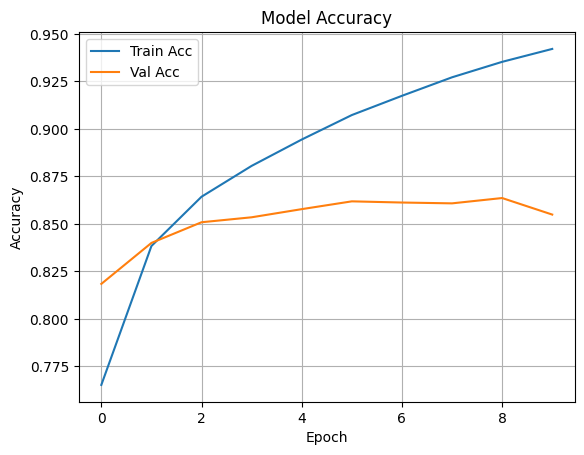

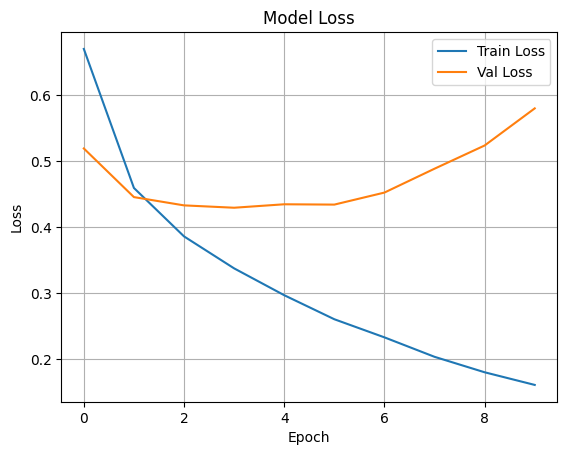

In [60]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [61]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


1257/1257 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8579 - loss: 0.5727
Test Accuracy: 0.8579, Test Loss: 0.5727


In [62]:
model.save("combined_image_classifier.h5")
